In [1]:
# import libraries
from cil.framework import BlockDataContainer
from cil.optimisation.functions import L2NormSquared, OperatorCompositionFunction
from cil.optimisation.operators import GradientOperator, BlockOperator, IdentityOperator
from cil.optimisation.algorithms import PDHG, CGLS, FISTA
from cil.utilities import dataexample
from cil.utilities import noise
from cil.utilities.display import show2D

import numpy as np

from skimage.metrics import structural_similarity as ssim

In [3]:
# Load an image from the CIL gallery. 
data = dataexample.SHAPES.get()
ig = data.geometry   

In [4]:
# Add gaussian noise
noisy_data = noise.gaussian(data, seed = 10, var = 0.005)

In [5]:
alpha = 10

In [6]:
algorithms = ["CGLS", "FISTA", "PDHG"]

for algo in algorithms:
    
    if algo == "CGLS":
        
        # Setup CGLS algorithm with BlockFramework
        Grad = GradientOperator(ig)
        K = BlockOperator(IdentityOperator(ig), np.sqrt(alpha)*Grad)
        b = BlockDataContainer(noisy_data, Grad.range.allocate())

        cgls = CGLS(initial = ig.allocate(), operator = K, data = b,
                      max_iteration = 500, update_objective_interval = 100, tolerance=1e-12)
        cgls.run()  
        
    elif algo == "FISTA":
        
        # Setup FISTA algorithm 
        G = L2NormSquared(b=noisy_data)
        F = OperatorCompositionFunction(alpha * L2NormSquared(), GradientOperator(ig))

        fista = FISTA(initial = ig.allocate(), f = F, g = G, 
                      max_iteration = 500, update_objective_interval = 100)
        fista.run()   
        
    elif algo == "PDHG":
        
        # Setup PDHG algorithm
        F = alpha * L2NormSquared()
        G = L2NormSquared(b=noisy_data)
        K = GradientOperator(ig)

        # Compute operator Norm
        normK = K.norm()

        # Primal & dual stepsizes
        sigma = 1.
        tau = 1/(sigma*normK**2)

        # Setup and run the PDHG algorithm
        pdhg = PDHG(f=F, g=G, operator=K, tau=tau, sigma=sigma,
                    max_iteration = 500, update_objective_interval = 100)
        pdhg.run(verbose=2)                

Initialised GradientOperator with C backend running with  20  threads
CGLS setting up
CGLS configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          2.06766e+04
      100        500         0.002          1.13071e+03
      200        500         0.002          1.13071e+03
      300        500         0.002          1.13071e+03
      400        500         0.002          1.13071e+03
      500        500         0.002          1.13071e+03
-------------------------------------------------------
      500        500         0.002          1.13071e+03
Stop criterion has been reached.

Initialised GradientOperator with C backend running with  20  threads
FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          2.06766e+04
      100        500         0.0

In [7]:
# Compute SSIM from Scikit-Image
cgls_ssim = ssim(data.as_array(), cgls.solution.as_array(), data_range = 1.)
fista_ssim = ssim(data.as_array(), fista.solution.as_array(), data_range = 1.)
pdhg_ssim = ssim(data.as_array(), pdhg.solution.as_array(), data_range = 1.)

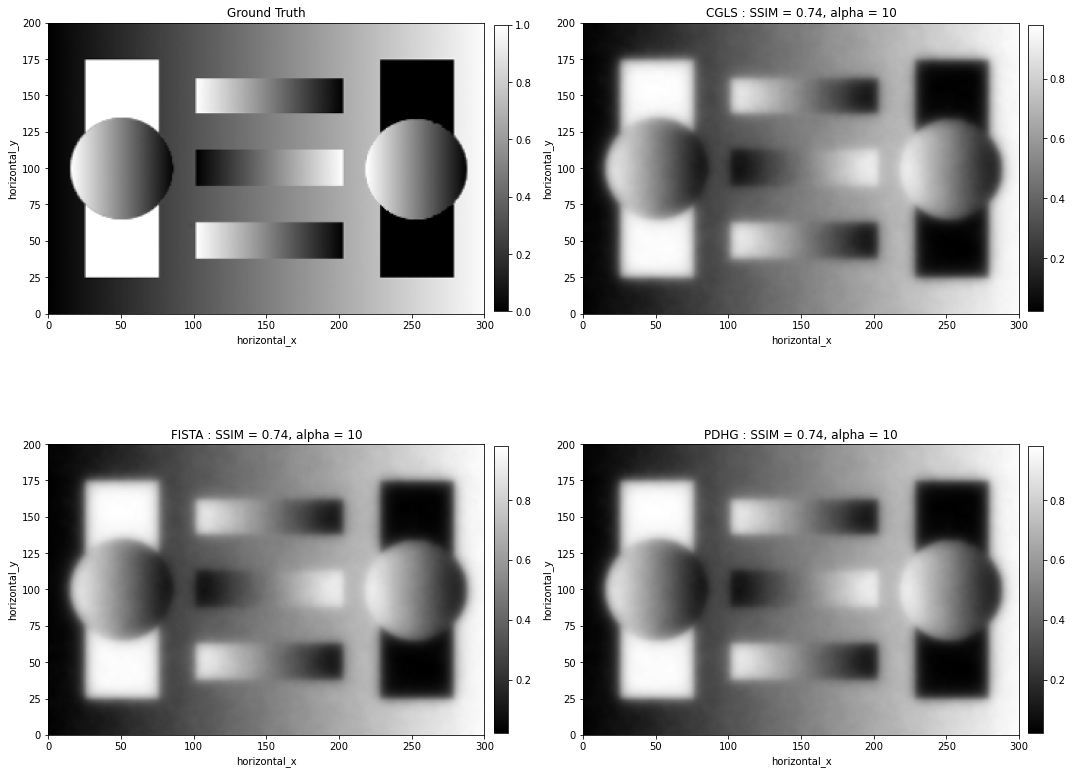

In [10]:
show2D([data, cgls.solution, fista.solution, pdhg.solution],
          title=["Ground Truth", 
                  "CGLS : SSIM = {:.2f}, alpha = {}".format(cgls_ssim, alpha), 
                  "FISTA : SSIM = {:.2f}, alpha = {}".format(fista_ssim, alpha),
                  "PDHG : SSIM = {:.2f}, alpha = {}".format(pdhg_ssim, alpha)])